# Lagrange Interpolation

If we are given $N+1$ datapoints $(x_0, y_0), \ldots, (x_N, y_N)$, we may fit a unique $N$th order polynomial:
$$
p(x) = \sum_{n=0}^N a_n x^n
$$
through these points by solving the linear system of equations:
$$
\begin{aligned}
a_0 + a_1 x_0 + a_2 x_0^2 + \ldots + a_N x_0^N &= y_0 \\
a_0 + a_1 x_1 + a_2 x_1^2 + \ldots + a_N x_1^N &= y_1 \\
\vdots \\
a_0 + a_1 x_N + a_2 x_N^2 + \ldots + a_N x_N^N &= y_N
\end{aligned}
$$
or, expressed in matrix notation:
$$
\begin{pmatrix}
1      & x_0    & x_0^2  & \cdots & x_0^N  \\
1      & x_1    & x_1^2  & \cdots & x_1^N  \\
\vdots & \vdots & \vdots & \vdots & \vdots \\
1      & x_N    & x_N^2  & \cdots & x_N^N
\end{pmatrix}
\begin{pmatrix}
a_0    \\
a_1    \\
\vdots \\
a_N
\end{pmatrix}
= 
\begin{pmatrix}
y_0    \\
y_1    \\
\vdots \\
y_N
\end{pmatrix}
$$
The matrix containing the powers of $x$ is often called Vandermonde matrix. Let's examine an example where we want to find a 3rd order interpolant that passes through sample values given at $x_0 = -1, x_1 = 0, x_2 = 1, x_3 = 2$ as $y_0 = 1, y_1 = 2, y_2 = -1, y_3 = 1$. In order to use the matrix equation directly, we will have to establish the Vandermonde matrix from the $x$-values, take the $y$-values as right hand side vector and invoke a linear system solver to find our vector of polynomial coefficients. Let's write some python code for that:

In [1]:
from numpy import *

def intpoly1(x, y):             # computes polynomial interpolation coefficients
    N = len(x)                  # supposed to be the same as len(y)
    v = zeros((N, N))           # allocate Vandermonde matrix
    for i in range(0, N):
        for j in range(0, N):
            v[i, j] = x[i]**j   # values of Vandermode matrix
    a = linalg.solve(v, y)      # solve the linear system
    return a
        
x = array([-1, 0,  1, 2])       # example x-values
y = array([ 1, 2, -1, 1])       # example y-values
a = intpoly1(x, y)

Our vector $a$ now contains the coefficients for the interpolating polynomial - let's use them to produce a densely sampled (pseudo-continuous) interpolated function plot which also show the original datapoints:

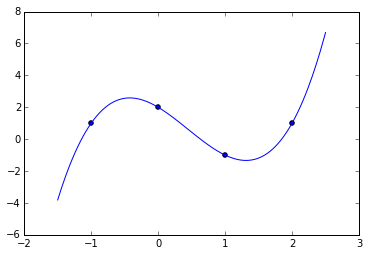

In [2]:
from matplotlib.pyplot import *
%matplotlib inline

Np = 201
xp = linspace(-1.5, 2.5, Np)     # x-axis values
yp = zeros(Np)
for i in range(0, Np):
    yp[i] = a[0] + a[1]*xp[i] + a[2]*xp[i]**2 + a[3]*xp[i]**3
plot(xp, yp)
scatter(x, y)

As we can see, the interpolating function passes through our datapoints, as it should be. Throwing a general linear system solver such as Gaussian elimination at the system will require memory of order $\mathcal{O}(N^2)$ for storing the matrix and computation time of order $\mathcal{O}(N^3)$ for the execution of the elimination algorithm. A more efficient approach can be found by considering the Lagrange interpolation formula, which is given by:
$$
p(x) = \sum_{n=0}^N y_n \prod_{k=0, k\neq n}^{N} \frac{x - x_k}{x_n - x_k}
$$
As it stands, the formula only allows us to produce interpolated function values at arbitrary abscissa values - it doesn't really tell us much about the polynomial coefficients $a_n$. We may, however, derive an algorithm for obtaining these coefficients from the formula. We see that the formula computes a weighted sum of products. The products themselves are $N$th order polynomials in product form, i.e. expressed as product of differences between the $x$-value and the roots of the polynomial. The denominators are actually just numbers that can be computed by a multiplicative accumulation in a loop over $k$. The numerators are polynomials of order $N$ which may also be computed by multiplicative accumulation loop - just that in this case, we need to use polynomial multiplication - which is convolution. We can accumulate numerator and denominator inside the same loop. To perform the sum, we would wrap an outer loop over $n$ around the $k$-loop. This outer loop performs an additive weighted accumulation of the actual polynomial coefficients. The overall algorithm could look like:

In [3]:
def intpoly2(x, y):
    N = len(x)                  # supposed to be the same as len(y)
    a = zeros(N)                # allocate Vandermonde matrix
    for n in range(0, N):
        num = 1
        den = 1        
        for k in range(0, N):
            if k != n:
                num  = convolve(num, [-x[k], 1])
                den *= (x[n] - x[k])
        a += (y[n]/den) * num
    return a

Note that the accumulative convolution just convolves with a $1$st order polynomial at a time, so it's not as expensive as it may look at first. Perhaps a specifically optimized function that multiplies a polynomial by a monomial could be used for that in production code. This function computes the same vector of polynomial coefficients without allocating a matrix and without invoking a linear system solver. It uses only $\mathcal{O}(N)$ of memory and $\mathcal{O}(N^2)$ of time. Let's verify that the algorithm actually computes the correct coefficients for our example:

In [4]:
a2 = intpoly2(x, y)
print(a)
print(a2)

[ 2.  -2.5 -2.   1.5]
[ 2.  -2.5 -2.   1.5]


Yep - it seems to work.

In some applications, the $x$-values are fixed but we get a lot of different $y$-values. In this case, it makes sense to precompute all the basis polynomials (the products inside the sum) such that only the outer loop (the sum over $n$) has to be performed to obtain different coefficient vectors. The <code>lagpolys</code> function precomputes The Lagrange basis polynomials defined as:
$$
L_{nk}(x) = \prod_{k=0, k\neq n}^{N} \frac{x - x_k}{x_n - x_k}
$$
and stores them in a matrix for later use:

In [5]:
def diffprod(x, n):        # product of differences x[n]-x[k] for all k!=n
    p = 1
    for k in range(0, len(x)):
        if k != n:
            p *= x[n]-x[k]
    return p

def lagpoly(x, n):         # n-th Lagrange basis polynomial
    p = 1
    for k in range(0, len(x)):
        if k != n:
            p = convolve(p, [-x[k], 1])
    return p / diffprod(x, n)

def lagpolys(x):           # matrix of all Lagrange basis polynomials
    N = len(x)
    L = zeros((N, N))
    for n in range(0, N):
        L[n, :] = lagpoly(x, n)
    return L


L  = lagpolys(x)           # precompute Lagrange basis polynomials
a3 = zeros(4)
for n in range(0, 4):
    a3 += y[n] * L[n, :]   # construct interpolating polynomial
print(a3)                  # verify that the result is correct
print(L)                   # print the basis polynomials

[ 2.  -2.5 -2.   1.5]
[[-0.         -0.33333333  0.5        -0.16666667]
 [ 1.         -0.5        -1.          0.5       ]
 [-0.          1.          0.5        -0.5       ]
 [ 0.         -0.16666667  0.          0.16666667]]


As another optimization, we could note that we have to perform $n$ polynomial products where for each $n$ we just leave out one single linear factor (the $k=n$ case). Instead of recomputing the product each time (for each $n$) from scratch, we might compute the product with the $k=n$ case included and then divide out one $x - x_k$ factor at a time. That would replace the repeated convolutions (polynomial multiplications) with a single deconvolution (polynomial division) for each $n$. Unfortunately, that doesn't seem to work - why?

In [6]:
def lagpolys2(x):
    N = len(x)
    L = zeros((N, N))      
    p = 1
    for k in range(0, N):
        p = convolve(p, [-x[k], 1])     # master polynomial
    for n in range(0, N):
        q, r = polydiv(p, [-x[n], 1])   # divide out single factor at a time
        L[n, :] = q / diffprod(x, n)   
    return L

L2 = lagpolys2(x)
print(L2)

[[-0.         -0.33333333  0.5        -0.16666667]
 [        nan         nan         nan         nan]
 [ 0.          1.          0.5        -0.5       ]
 [-0.         -0.16666667 -0.          0.16666667]]


C:\Users\Rob\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:892: RuntimeWarning: divide by zero encountered in double_scalars
  scale = 1. / v[0]
C:\Users\Rob\Anaconda3\lib\site-packages\numpy\lib\polynomial.py:896: RuntimeWarning: invalid value encountered in double_scalars
  d = scale * r[k]
